## Time Series Classification of Human Activity Recognition
##Sonali B Sreedhar
##sbsreedh@usc.edu
##USC ID: 1783668369

#### Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29 . The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities of the same person. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values. 
#### Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [105]:
#import libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression, LassoCV,LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import StandardScaler,label_binarize, normalize
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve, auc,roc_auc_score
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [106]:
cd /Users/sonalisreedhar/Desktop/AReM/AReM

/Users/sonalisreedhar/Desktop/AReM/AReM


In [107]:
data_dict = 'AReM/'
prefix = 'dataset'
filetype = '.csv'
classes = ['walking', 'standing', 'sitting', 'lying', 'cycling', 'bending1', 'bending2']

In [108]:
#variable declarations
data_path = os.getcwd() + '/dataset'

def create_header(names):
    imp_list = []
    for i in range(1, 7):
        for label in names:
            imp_list.append(label + str(i))
    return imp_list


col_headers = create_header(
    ['min', 'max', 'mean', 'median', 'std_dev', '1st_quart', '3rd_quart'])
col_headers.append('class')
imp_headers = create_header(['median', 'std_dev', '1st_quart'])
imp_headers.append('class')
feature_cols = np.delete(col_headers, 42)

### Data Splitting and Feature Extraction

##### (c) i. Different time domain features used in time series classification are: Minimum, Maximum, Standard Deviation, Mean, 1st Quartile, 3rd Quartile

#### (c) ii. Load Data

In [109]:
#read data and split into test and train files
def train_test_split(data_path):
   
    train_files = []
    test_files = []
    exclude_binding_dataset = ['dataset1.csv', 'dataset2.csv']
    exclude_dataset = ['dataset1.csv', 'dataset2.csv', 'dataset3.csv']
    for act in os.listdir(data_path):
        names = os.listdir(data_path + '/' + act)
        if 'bending' in act:
            train_files = train_files + [
                act + '/' + f for f in names
                if f not in exclude_binding_dataset
            ]
            test_files = test_files + [
                act + '/' + s for s in exclude_binding_dataset
            ]
        else:
            train_files = train_files + [
                act + '/' + f for f in names if f not in exclude_dataset
            ]
            test_files = test_files + [act + '/' + s for s in exclude_dataset]
    
    return train_files, test_files


#get time domain featuers for each instance
def get_features(file, split_time_series=None, multi_class = None):
    instance_list = []
    file = data_path + '/' + file
    if 'bending' in file:
        class_type = 1
    else:
        class_type = 0
    df = pd.read_csv(file, header=4, usecols=[*range(1, 7)])
    #df = df.reset_index()
    df.fillna(0, inplace=True)
    #df.fillna(0)
    dflist = [df]
    if split_time_series is not None:
        dflist = np.array_split(df, split_time_series)
    for df in dflist:
        row = []
        stat_df = df.agg(['min', 'max', 'mean', 'median', 'std'])
        #stat_df .head()
        stat_df = stat_df.append(df.quantile(q=0.25))
        stat_df = stat_df.append(df.quantile(q=0.75))
        for col in [stat_df[f] for f in stat_df]:
            for data in col:
                row.append(data)
        row.append(class_type)
        instance_list.append(row)
    return instance_list

def get_instance_frame(file_list,split_size=None):
    total_instance_frame = pd.DataFrame()
    total_instance_list = []
    for file in file_list:
        instance_features = get_features(file,split_size)
        total_instance_list = total_instance_list + instance_features

    total_instance_frame = pd.DataFrame(total_instance_list, columns=col_headers)
    return total_instance_frame
    

In [110]:
train_files, test_files = train_test_split(data_path)
#train_files = train_files.reset_index()
#test_files = test_files.reset_index()

#print(train_files)

##### (c) iii The three important time domain features selected are median, std deviation and 1st quartile (using feature selection method)

### Binary Classification Using Logistic Regression

#### (d) i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iii extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. 

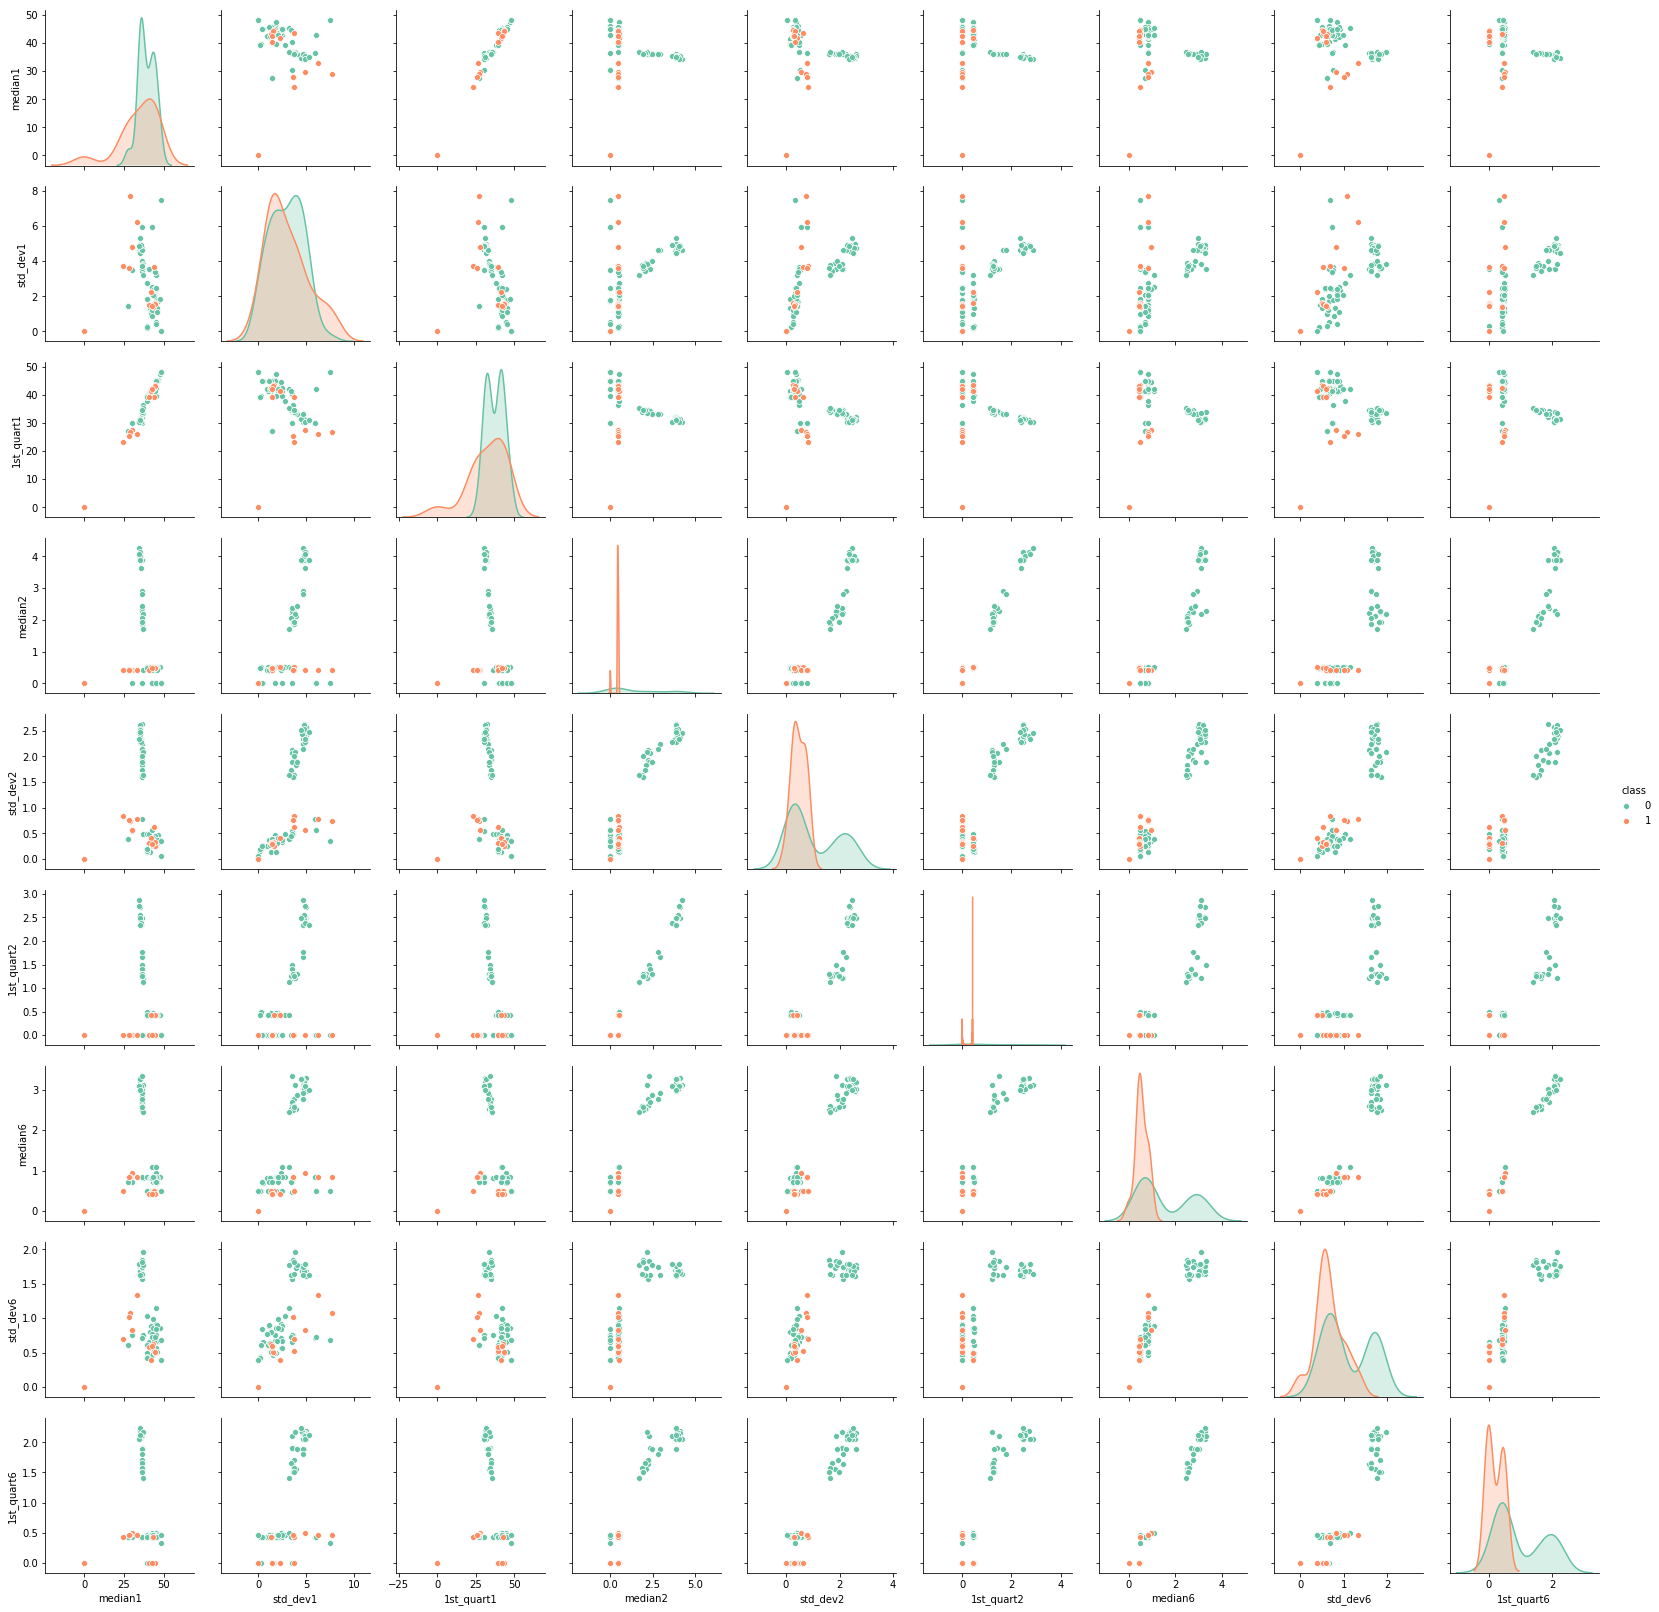

In [111]:
total_instance_frame = get_instance_frame(train_files + test_files, 1)
total_selected_frame = total_instance_frame[imp_headers]
scatter_plot = sns.pairplot(data=total_selected_frame, vars= ['median1','std_dev1','1st_quart1',
                  'median2','std_dev2','1st_quart2','median6','std_dev6','1st_quart6'], kind='scatter', palette="Set2",hue='class')

#### (d) ii.  Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the 88 instances, you have 12 time series for each instance. Repeat the experiment in 1(d)i. Do you see any considerable difference in the results with those of 1(d)i?

##### - After breaking each  time series into two, the scatters plot of different classes look more seperatable

<Figure size 432x288 with 0 Axes>

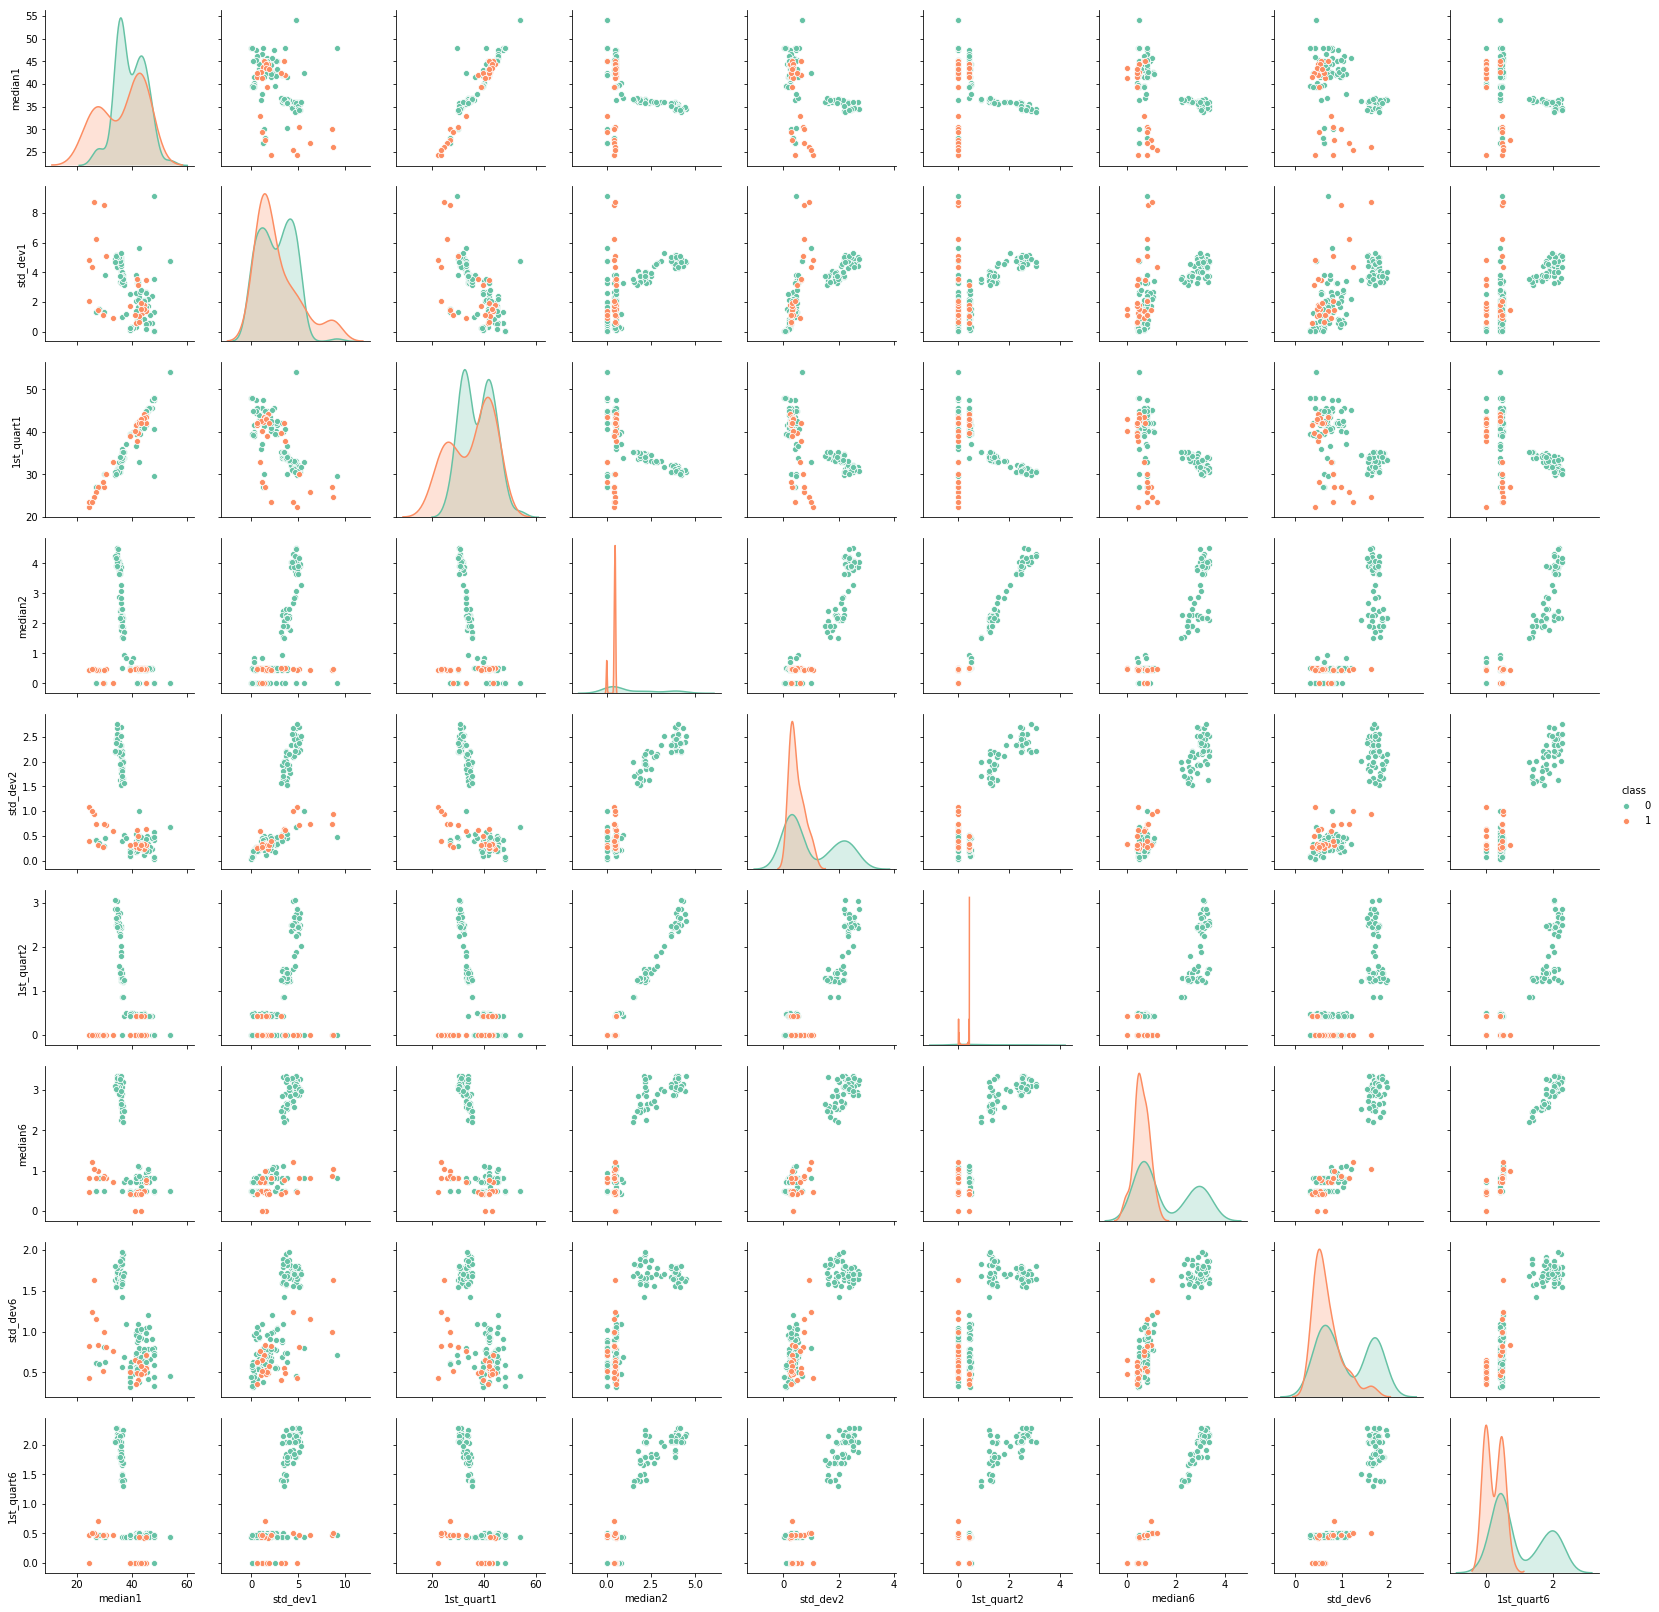

<Figure size 432x288 with 0 Axes>

In [33]:
total_instance_frame = get_instance_frame(train_files + test_files, 2)
total_selected_frame = total_instance_frame[imp_headers]
scatter_plot = sns.pairplot(data=total_selected_frame, vars= ['median1','std_dev1','1st_quart1',
                  'median2','std_dev2','1st_quart2','median6','std_dev6','1st_quart6'], kind='scatter', palette="Set2",hue='class')
plt.figure()

#### (d) iii.  Break each time series in your training set into l ∈ {1,2,...,20} time series of approximately equal length and use logistic regression 5 to solve the binary classification problem, using time-domain features. Calculate the p-values for your logistic regression parameters and refit a logistic regression model using your pruned set of features. 6 Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of l. Explain what the right way and the wrong way are to perform cross-validation in this problem. 7 Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.

###### - The right way to perform cross validation is on both L and variable selection. To avoid problem of class balance, we have also used startified cross validation

In [101]:
feature_cols = np.delete(col_headers, 42)
best_cv_score = 0
best_l = 0

for l in range(1,10):
    Y_train = train_instance_list = []
    X_train = train_instance_frame = pd.DataFrame()
   
    
    
    train_instance_frame = get_instance_frame(train_files, l)
    
    Y_train = train_instance_frame['class']
    X_train = train_instance_frame.drop(['class'], axis=1)
    #print(X_train)
    logreg = LogisticRegression()    
    for i in range(1,len(X_train.columns)):
        rfe_res = RFE(estimator=logreg, n_features_to_select= i)
        rfe_res.fit(X_train, Y_train)
        cv_score = cross_val_score(rfe_res, X_train, Y_train, cv=5, scoring='accuracy')  
        mean_score  =  np.mean(cv_score)
        if mean_score > best_cv_score:
            best_cv_score = mean_score
            n_features = i   
            best_l = l
            best_features = feature_cols[rfe_res.support_]

print("The best value of L for Logistic Regression is :" , best_l )            
print("Optimal cv score for Logistic Regression is :" , best_cv_score)
print("Optimal number of features for Logistic Regression is : " , n_features)
print("The Optimal features for Logistic Regression are : ", best_features)


The best value of L for Logistic Regression is : 1
Optimal cv score for Logistic Regression is : 0.9428571428571428
Optimal number of features for Logistic Regression is :  9
The Optimal features for Logistic Regression are :  ['mean1' '3rd_quart1' 'max2' 'median3' 'min5' 'max5' 'mean5' '1st_quart5'
 'max6']


In [88]:
X_train.shape


(69, 42)

#### (d) iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression β i ’s as well as the p-values associated with them.

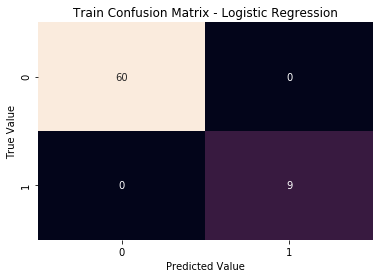

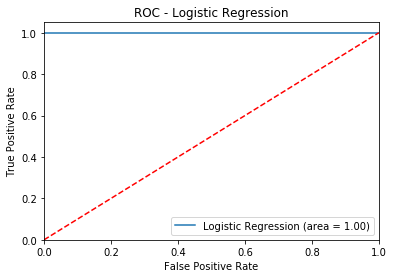

In [113]:
train_instance_frame = get_instance_frame(train_files, best_l)
Y_train = train_instance_frame['class']
X_train = train_instance_frame.drop(['class'], axis=1)
X_train = X_train[best_features]
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_train)

conf_mat = confusion_matrix(Y_train, Y_pred)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, cbar= False, ax = ax);
plt.title('Train Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

roc_auc = roc_auc_score(Y_train, Y_pred)
fp_rate, tp_rate, thresholds = roc_curve(Y_train, Y_pred)
plt.figure()
plt.plot(fp_rate, tp_rate, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [114]:
logit_model=sm.Logit(Y_train,X_train)
result=logit_model.fit(maxiter = 21)
result.summary()

         Current function value: 0.010046
         Iterations: 21


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  class   No. Observations:                   69
Model:                          Logit   Df Residuals:                       60
Method:                           MLE   Df Model:                            8
Date:                Wed, 26 Jun 2019   Pseudo R-squ.:                  0.9741
Time:                        08:34:05   Log-Likelihood:               -0.69315
converged:                      False   LL-Null:                       -26.718
                                        LLR p-value:                 1.647e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mean1         -1.5710   5764.138     -0.000      1.000   -1.13e+04    1.13e+04
3rd_quart1    -1.8172   5735.247     -0.000      1.000   -1.12e+04    1.12e+04
max2          -0.4959   3239.569     -0.000      1.000   -6349.934    6348.942
median3       -1.5767   1528.338     -0.001      0.999   -2997.064    2993.911
min5           2.7259   4824.987      0.001      1.000   -9454.075    9459.527
max5           3.6386   3445.513      0.001      0.999   -6749.443    6756.720
mean5          2.1750   2.59e+04   8.39e-05      1.000   -5.08e+04    5.08e+04
1st_quart5     0.4957   1.72e+04   2.89e-05      1.000   -3.36e+04    3.36e+04
max6          -2.1592   4957.298     -0.000      1.000   -9718.284    9713.965
==============================================================================

Possibly complete quasi-separation: A fraction 0.99 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

##### - In the above logit Regression output, coef_ column gives us Beta parameter values and p-values are given by P>|z| column

#### (d) v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

The Test Accuracy is : 1


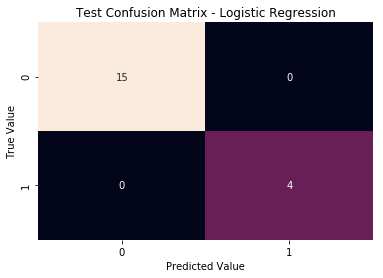

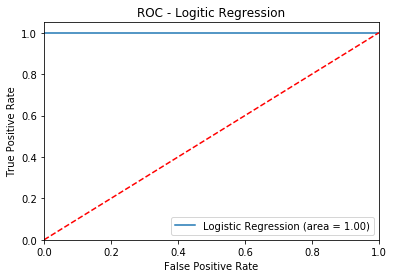

In [115]:
test_instance_frame = get_instance_frame(test_files, best_l)
Y_test = test_instance_frame['class']
X_test = test_instance_frame.drop(['class'], axis=1)
X_test = X_test[best_features]

Y_pred = logreg.predict(X_test)
print("The Test Accuracy is : %d" %metrics.accuracy_score(Y_test, Y_pred) )            

conf_mat = confusion_matrix(Y_test, Y_pred)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, cbar= False, ax = ax);
plt.title('Test Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

roc_auc = roc_auc_score(Y_test, Y_pred)
fp_rate, tp_rate, thresholds = roc_curve(Y_test, Y_pred)
plt.figure()
plt.plot(fp_rate, tp_rate, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Logitic Regression')
plt.legend(loc="lower right")
plt.show()



#### d (vi) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?
##### - Yes, from the warning of statsmodel code we find that classes are well-separated thereby resulting in instability in calculating beta and p-values

#### d (vii) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

In [116]:
feature_cols = np.delete(col_headers, 42)
best_cv_score = 0
best_l = 0
for l in range(1,21):
    Y_train = train_instance_list = []
    X_train = train_instance_frame = pd.DataFrame()
    train_instance_frame = get_instance_frame(train_files, l)
    
    Y_train = train_instance_frame['class']
    X_train = train_instance_frame.drop(['class'], axis=1)
    
    rus = RandomUnderSampler()
    X_sampled_train, y_sampled_train = rus.fit_sample(X_train, Y_train)
    
    logreg = LogisticRegression()    
    for i in range(1,len(X_train.columns)):
        rfe_res = RFE(estimator=logreg, n_features_to_select= i)
        rfe_res.fit(X_sampled_train, y_sampled_train)
        cv_score = cross_val_score(rfe_res, X_sampled_train, y_sampled_train, cv=5, scoring='accuracy')  
        mean_score  =  np.mean(cv_score)
        if mean_score > best_cv_score:
            best_cv_score = mean_score
            n_features = i   
            best_l = l
            best_features = feature_cols[rfe_res.support_]

print("The best value of L for case control sampling is :" , best_l )            
print("Optimal CV score for case control sampling is :" , best_cv_score)
print("Optimal number of features for case control sampling : " , n_features)
print("The Optimal features for for case control sampling are : ", best_features)

The best value of L for case control sampling is : 1
Optimal CV score for case control sampling is : 0.95
Optimal number of features for case control sampling :  3
The Optimal features for for case control sampling are :  ['3rd_quart1' 'max2' 'max5']


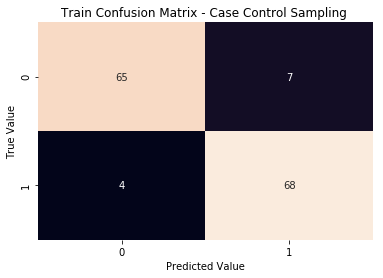

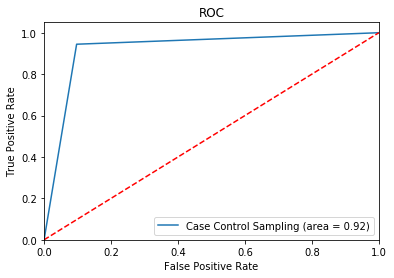

In [58]:
train_files, test_files = train_test_split(data_path)

train_instance_frame = get_instance_frame(train_files, best_l)
Y_train = train_instance_frame['class']
X_train = train_instance_frame.drop(['class'], axis=1)
X_train = X_train[best_features]

X_sampled_train, y_sampled_train =  RandomUnderSampler().fit_sample(X_train, Y_train)
    
logreg = LogisticRegression()
logreg.fit(X_sampled_train, y_sampled_train)
Y_pred = logreg.predict(X_sampled_train)

conf_mat = confusion_matrix(y_sampled_train, Y_pred)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, cbar= False, ax = ax);
plt.title('Train Confusion Matrix - Case Control Sampling ')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

roc_auc = roc_auc_score(y_sampled_train, Y_pred)
fpr, tpr, thresholds = roc_curve(y_sampled_train, Y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Case Control Sampling (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

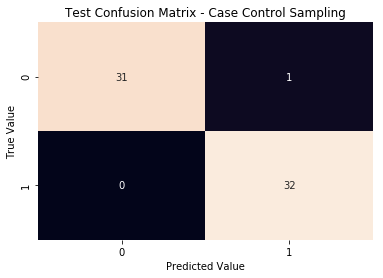

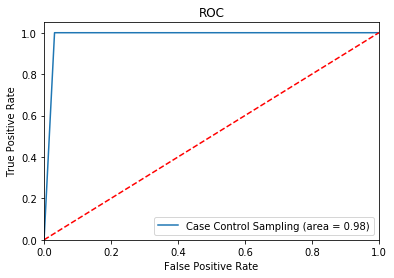

In [59]:
train_files, test_files = train_test_split(data_path)

test_instance_frame = get_instance_frame(test_files, best_l)
Y_test = test_instance_frame['class']
X_test = test_instance_frame.drop(['class'], axis=1)
X_test = X_test[best_features]

X_sampled_test, y_sampled_test =  RandomUnderSampler().fit_sample(X_test, Y_test)

Y_pred = logreg.predict(X_sampled_test)

conf_mat = confusion_matrix(y_sampled_test, Y_pred)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, cbar= False, ax = ax);
plt.title('Test Confusion Matrix - Case Control Sampling')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

roc_auc = roc_auc_score(y_sampled_test, Y_pred)
fpr, tpr, thresholds = roc_curve(y_sampled_test, Y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Case Control Sampling (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### Binary Classification Using L 1 -penalized logistic regression

#### e (i) Repeat 1(d)iii using L 1 -penalized logistic regression, 8 i.e. instead of using p-values for variable selection, use L 1 regularization. Note that in this problem,you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L 1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically. 

In [60]:
train_files, test_files = train_test_split(data_path)

best_l = 0
best_cv_score = 0 
for l in range(1,21):
    Y_train = []
    X_train = pd.DataFrame()
    train_instance_frame = get_instance_frame(train_files, l)
    Y_train = train_instance_frame['class']
    X_train = train_instance_frame.drop(['class'], axis=1)
    
    #normalization
    scalar = StandardScaler()
    X_train  = scalar.fit_transform(X_train)
    
    lasso = LogisticRegressionCV(penalty = 'l1',cv=StratifiedKFold(5),solver='saga')
    lasso = lasso.fit(X_train, Y_train)
    cv_score = cross_val_score(lasso, X_train, Y_train, cv=StratifiedKFold(5), scoring='accuracy')  
    mean_score  =  np.mean(cv_score)
    if mean_score > best_cv_score:
        best_cv_score = mean_score
        best_l = l
        best_C = lasso.C_[0]

print("The best L-value for binary Log Reg L1 Penalty is : ", best_l )
print("The best C-value for binary Log Reg L1 Penalty : " ,best_C )
print("Optimal CV score for binary Log Reg L1 Penalty: " ,  best_cv_score)

The best L-value for binary Log Reg L1 Penalty is :  4
The best C-value for binary Log Reg L1 Penalty :  0.3593813663804626
Optimal CV score for binary Log Reg L1 Penalty:  0.895064935064935


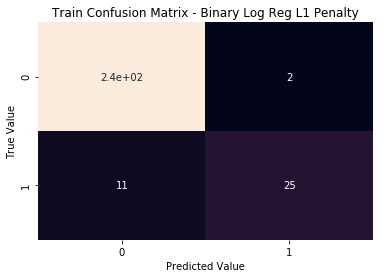

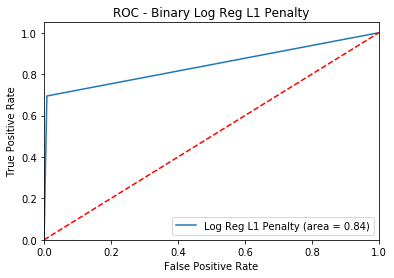

In [61]:
#perform binary L 1 -penalized logistic regression on train data using best L value and c-value obtained above
train_files, test_files = train_test_split(data_path)

train_instance_frame = get_instance_frame(train_files, best_l)
Y_train = train_instance_frame['class']
X_train = train_instance_frame.drop(['class'], axis=1)

#normalization
scalar = StandardScaler()
X_train  = scalar.fit_transform(X_train)

lasso = LogisticRegression(penalty = 'l1', C = best_C, solver='liblinear')
lasso = lasso.fit(X_train, Y_train)
Y_pred = lasso.predict(X_train)
conf_matrix = confusion_matrix(Y_train, Y_pred)

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, cbar= False, ax = ax);
plt.title('Train Confusion Matrix - Binary Log Reg L1 Penalty')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

roc_auc = roc_auc_score(Y_train, Y_pred)
fpr, tpr, thresholds = roc_curve(Y_train, Y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Log Reg L1 Penalty (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Binary Log Reg L1 Penalty')
plt.legend(loc="lower right")
plt.show()

Test Error rate for Binary Log Reg L1 penalty is :  0.02631578947368418


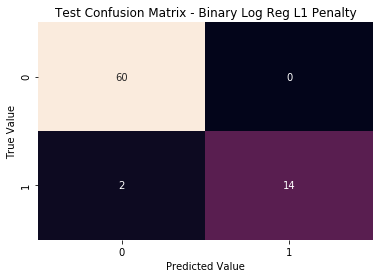

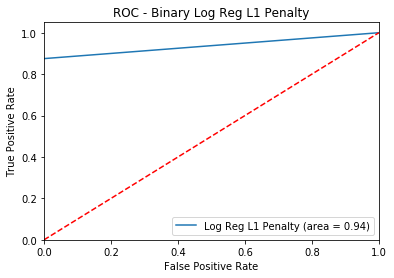

In [62]:
#perform binary L 1 -penalized logistic regression on test data using best L value and c-value obtained above
train_files, test_files = train_test_split(data_path)

test_instance_frame = get_instance_frame(test_files, best_l)
Y_test = test_instance_frame['class']
X_test = test_instance_frame.drop(['class'], axis=1)

scalar = StandardScaler()
X_test  = scalar.fit_transform(X_test)

Y_pred = lasso.predict(X_test)

accuracy = metrics.accuracy_score(Y_test, Y_pred)
print("Test Error rate for Binary Log Reg L1 penalty is : ", 1-accuracy )

conf_matrix = confusion_matrix(Y_test, Y_pred)
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, cbar= False, ax = ax);
plt.title('Test Confusion Matrix - Binary Log Reg L1 Penalty')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

roc_auc = roc_auc_score(Y_test, Y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Log Reg L1 Penalty (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Binary Log Reg L1 Penalty')
plt.legend(loc="lower right")
plt.show()

#### e (iii)  Compare the L 1 -penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?
##### - Logistic Regression with variable selection will perform better as it has higher CV than l1 penalized. However, l1 penalized regression is easier to implement as it avoids variable selection loop thereby reducing computational load

### Multi-class Classification

#### (i). Find the best l in the same way as you found it in 1(e)i to build an L 1 -penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [78]:
#get time domain featuers for each instance
multi_class_labels = ['bending1', 'bending2','cycling','lying', 'sitting', 'standing', 'walking']

def get_features_multi_class(file, split_time_series=None):
    instance_list = []
    class_type = file.split('/')[0]
    file = data_path + '/' + file
    df = pd.read_csv(file, header=4, usecols=[*range(1, 7)])
    df.fillna(0, inplace=True)
    dflist = [df]
    if split_time_series is not None:
        dflist = np.array_split(df, split_time_series)
    for df in dflist:
        row = []
        stat_df = df.agg(['min', 'max', 'mean', 'median', 'std'])
        stat_df = stat_df.append(df.quantile(q=0.25))
        stat_df = stat_df.append(df.quantile(q=0.75))
        for col in [stat_df[f] for f in stat_df]:
            for data in col:
                row.append(data)
        row.append(class_type)
        instance_list.append(row)
    return instance_list


def get_multi_class_instance_frame(file_list, split_size=None):
    total_instance_frame = pd.DataFrame()
    total_instance_list = []
    for file in file_list:
        instance_features = get_features_multi_class(file,split_size)
        total_instance_list = total_instance_list + instance_features

    total_instance_frame = pd.DataFrame(
        total_instance_list, columns=col_headers)
    return total_instance_frame

In [79]:
def multiclass_roc(y_true, y_pred):
    ''' 
        This function plots ROC curve with AUC for
        multiclass classification
    '''
    multi_class_labels = ['bending1', 'bending2','cycling', 'lying','sitting', 'standing', 'walking']
    lw=2
    fpr = tpr = roc_auc = dict()
    colors = ['purple','brown','blue','green','yellow','orange','red']
    for i in range(0,7):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i],
             lw=lw, label=f'ROC curve for {multi_class_labels[i]} (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [80]:
#perform L1-penalized multiclass logistic regression to find best L value

train_files, test_files = train_test_split(data_path)

best_l = 0
best_cv_score = 0
for l in range(1, 21):
    Y_train = []
    X_train = pd.DataFrame()
    train_instance_frame = get_multi_class_instance_frame(train_files, l)
    Y_train = train_instance_frame['class']
    X_train = train_instance_frame.drop(['class'], axis=1)

    #normalization
    scalar = StandardScaler()
    X_test  = scalar.fit_transform(X_test)

    multi_lasso = LogisticRegressionCV(
        penalty='l1',
        multi_class='multinomial',
        cv=3,
        solver='saga')
    multi_lasso = multi_lasso.fit(X_train, Y_train)
    cv_score = cross_val_score(
        multi_lasso, X_train, Y_train, cv=3, scoring='accuracy')
    mean_score = np.mean(cv_score)
    if mean_score > best_cv_score:
        best_cv_score = mean_score
        best_l = l
        best_C = multi_lasso.C_[0]
        
print("The best L-value Multiclass Log Reg L1 penalty is : ", best_l )
print("The best C-value Multiclass Log Reg L1 penalty is : " ,best_C )
print("Optimal CV score Multiclass Log Reg L1 penalty is: " ,  best_cv_score)

The best L-value Multiclass Log Reg L1 penalty is :  1
The best C-value Multiclass Log Reg L1 penalty is :  166.81005372000558
Optimal CV score Multiclass Log Reg L1 penalty is:  0.85677426438296


###### Note: We have used cv = 3 to avoid  number of samples warning resulting from limited samples in bending1 and bending2 dataset

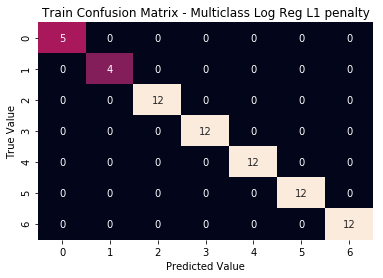

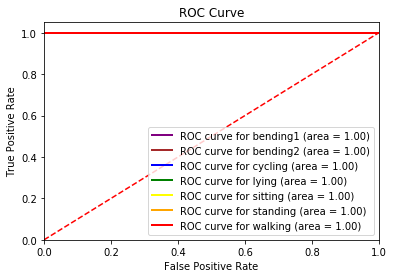

In [81]:
#perform L1-penalized multiclass logistic regression on train data using best L value and C value obtained from above

train_files, test_files = train_test_split(data_path)

train_instance_frame = get_multi_class_instance_frame(train_files, best_l)
Y_train = train_instance_frame['class']
X_train = train_instance_frame.drop(['class'], axis=1)

#normalization
scalar = StandardScaler()
X_train  = scalar.fit_transform(X_train)
multi_lasso = LogisticRegression(penalty = 'l1', C = best_C, multi_class='multinomial', solver='saga')
multi_lasso = multi_lasso.fit(X_train, Y_train)
Y_pred = multi_lasso.predict(X_train)

conf_matrix = confusion_matrix(Y_train, Y_pred)
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, cbar= False, ax = ax);
plt.title('Train Confusion Matrix - Multiclass Log Reg L1 penalty')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

Y_train = label_binarize(Y_train, classes= multi_class_labels)
Y_pred = label_binarize(Y_pred, classes= multi_class_labels)
multiclass_roc(Y_train, Y_pred)


Test Error rate for multi-class Log Reg L1 penalty is :  0.13157894736842102


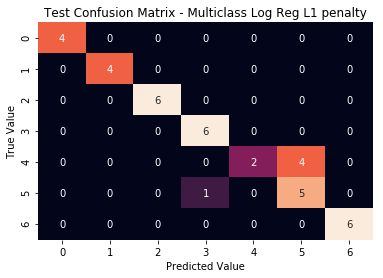

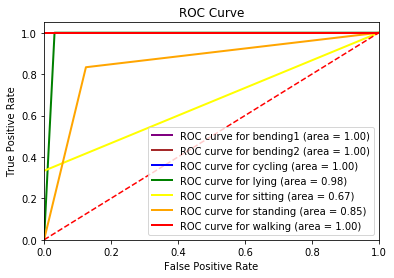

In [83]:
#perform L1-penalized multiclass logistic regression (L1 penalty)on test data using best L value

test_instance_frame = get_multi_class_instance_frame(test_files, best_l)
Y_test = test_instance_frame['class']
X_test = test_instance_frame.drop(['class'], axis=1)

#normalization
scalar = StandardScaler()
X_test  = scalar.fit_transform(X_test)
Y_pred = multi_lasso.predict(X_test)

accuracy = metrics.accuracy_score(Y_test, Y_pred)
print("Test Error rate for multi-class Log Reg L1 penalty is : ", 1-accuracy )
conf_matrix = confusion_matrix(Y_test, Y_pred)
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, cbar= False, ax = ax);
plt.title('Test Confusion Matrix - Multiclass Log Reg L1 penalty')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

Y_test = label_binarize(Y_test, classes= multi_class_labels)
Y_pred = label_binarize(Y_pred, classes= multi_class_labels)
multiclass_roc(Y_test, Y_pred)


#### e (ii) Repeat 1(f)i using a Naive Bayes’ classifier. Use both Gaussian and Multi-nomial priors and compare the results.

In [82]:
#perform multi-class Naive Bayes(Gaussian Prior) to find best L
train_files, test_files = train_test_split(data_path)

best_l = 0
best_cv_score = 0
for l in range(1, 21):
    train_instance_frame = get_multi_class_instance_frame(train_files, l)
    Y_train = train_instance_frame['class']
    X_train = train_instance_frame.drop(['class'], axis=1)
    nbgaussian = GaussianNB()
    nbgaussian = nbgaussian.fit(X_train, Y_train)
    cv_score = cross_val_score(
        nbgaussian, X_train, Y_train, cv=3, scoring='accuracy')
    mean_score = np.mean(cv_score)
    if mean_score > best_cv_score:
        best_cv_score = mean_score
        best_l = l

print("The best L-value for multiclass naive bayes (Gaussian Prior) is : ", best_l)
print("Optimal CV score for multiclass naive bayes (Gaussian Prior) is: ", best_cv_score)

The best L-value for multiclass naive bayes (Gaussian Prior) is :  2
Optimal CV score for multiclass naive bayes (Gaussian Prior) is:  0.7968787473875355


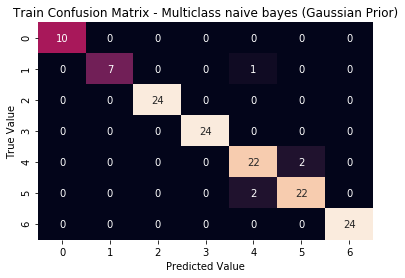

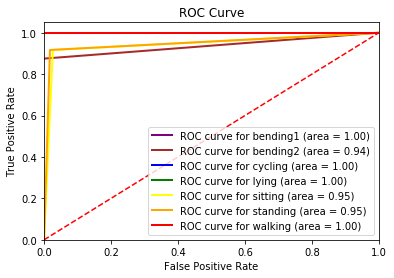

In [84]:
#perform multiclass naive bayes (Gaussian Prior) on train data using best L value obtained from above
train_files, test_files = train_test_split(data_path)

train_instance_frame = get_multi_class_instance_frame(train_files, best_l)
Y_train = train_instance_frame['class']
X_train = train_instance_frame.drop(['class'], axis=1)

nbgaussian = GaussianNB()
nbgaussian = nbgaussian.fit(X_train, Y_train)

Y_pred = nbgaussian.predict(X_train)
conf_matrix = confusion_matrix(Y_train, Y_pred)
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, cbar= False, ax = ax);
plt.title('Train Confusion Matrix - Multiclass naive bayes (Gaussian Prior)')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

Y_train = label_binarize(Y_train, classes= multi_class_labels)
Y_pred = label_binarize(Y_pred, classes= multi_class_labels)
multiclass_roc(Y_train, Y_pred)

Test Error rate for multiclass naive bayes(Gaussian Prior) is :  0.10526315789473684


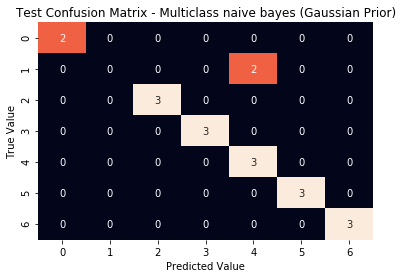

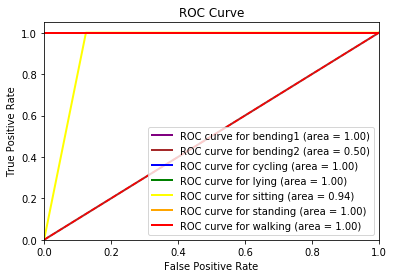

In [70]:
train_files, test_files = train_test_split(data_path)

#perform multiclass naive bayes (Gaussian Prior) on test data using best L value

test_instance_frame = get_multi_class_instance_frame(test_files, best_l)
Y_test = test_instance_frame['class']
X_test = test_instance_frame.drop(['class'], axis=1)

Y_pred = nbgaussian.predict(X_test)

accuracy = metrics.accuracy_score(Y_test, Y_pred)
print("Test Error rate for multiclass naive bayes(Gaussian Prior) is : ", 1-accuracy )
conf_matrix = confusion_matrix(Y_test, Y_pred)
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, cbar= False, ax = ax);
plt.title('Test Confusion Matrix - Multiclass naive bayes (Gaussian Prior)')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

Y_test = label_binarize(Y_test, classes= multi_class_labels)
Y_pred = label_binarize(Y_pred, classes= multi_class_labels)
multiclass_roc(Y_test, Y_pred)

In [103]:
train_files, test_files = train_test_split(data_path)

#perfor multi-class Naive Bayes(Multinomial Prior) to find best L
best_l = 0
best_cv_score = 0 
for l in range(1,21):
    train_instance_frame = get_multi_class_instance_frame(train_files, l)
    Y_train = train_instance_frame['class']
    X_train = train_instance_frame.drop(['class'], axis=1)
    nbmultinomial = MultinomialNB()
    #X_train.dropna()
    #print(X_train)
    nbmultinomial = nbmultinomial.fit(X_train, Y_train)
    cv_score = cross_val_score(nbmultinomial, X_train, Y_train, cv = 3, scoring='accuracy')  
    mean_score  =  np.mean(cv_score)
    if mean_score > best_cv_score:
        best_cv_score = mean_score
        best_l = l

print("The best L-value for multiclass naive bayes (Multinomial Prior) is : ", best_l )
print("Optimal CV score for multiclass naive bayes (Multinomial Prior) is: " ,  best_cv_score)

The best L-value for multiclass naive bayes (Multinomial Prior) is :  1
Optimal CV score for multiclass naive bayes (Multinomial Prior) is:  0.8416227492314449


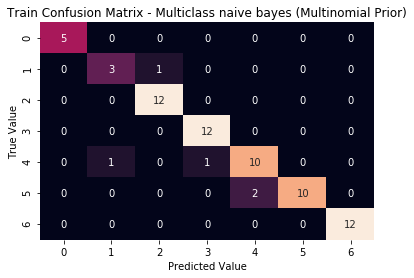

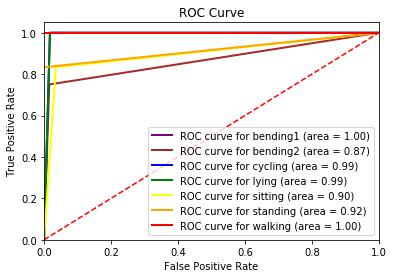

In [86]:
#perform multi-class Naive Bayes(Multinomial Prior) on train data using best L value
train_files, test_files = train_test_split(data_path)
best_l = 1
train_instance_frame = get_multi_class_instance_frame(train_files, best_l)
Y_train = train_instance_frame['class']
X_train = train_instance_frame.drop(['class'], axis=1)

nbmultinomial = MultinomialNB()
#X_train_norm=normalize(X_train)
#Y_train_norm=normalize(Y_train)
nbmultinomial = nbmultinomial.fit(X_train, Y_train)

Y_pred = nbmultinomial.predict(X_train)

conf_matrix = confusion_matrix(Y_train, Y_pred)
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, cbar= False, ax = ax);
plt.title('Train Confusion Matrix - Multiclass naive bayes (Multinomial Prior)')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

Y_train = label_binarize(Y_train, classes= multi_class_labels)
Y_pred = label_binarize(Y_pred, classes= multi_class_labels)
multiclass_roc(Y_train, Y_pred)

Test Error rate for multiclass naive bayes(Multinomial Prior) is :  0.10526315789473684


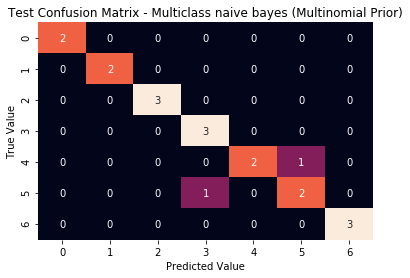

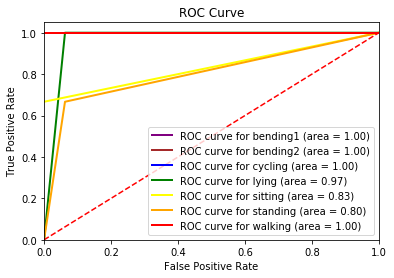

In [87]:
#perform multi-class Naive Bayes(Multinomial Prior) on test data using best L value

train_files, test_files = train_test_split(data_path)
test_instance_frame = get_multi_class_instance_frame(test_files, best_l)
Y_test = test_instance_frame['class']
X_test = test_instance_frame.drop(['class'], axis=1)

Y_pred = nbmultinomial.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)

accuracy = metrics.accuracy_score(Y_test, Y_pred)
print("Test Error rate for multiclass naive bayes(Multinomial Prior) is : ", 1-accuracy )
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, cbar= False, ax = ax);
plt.title('Test Confusion Matrix - Multiclass naive bayes (Multinomial Prior)')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

Y_test = label_binarize(Y_test, classes= multi_class_labels)
Y_pred = label_binarize(Y_pred, classes= multi_class_labels)
multiclass_roc(Y_test, Y_pred)

#### e (iii) Which method is better for multi-class classification in this problem?

 ##### - After comparation, we observe that  L1-norm logistic regression has the best performance here with this dataset.